In [1]:
!git clone https://github.com/CASIA-IVA-Lab/FastSAM.git
%pip  install -r FastSAM/requirements.txt
# install CLIP
%pip  install git+https://github.com/openai/CLIP.git
# install SAM
%pip  install git+https://github.com/facebookresearch/segment-anything.git
# install other dependencies
%pip  install roboflow supervision jupyter_bbox_widget
%pip install roboflow

Cloning into 'FastSAM'...
remote: Enumerating objects: 1171, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 1171 (delta 201), reused 186 (delta 186), pack-reused 929
Receiving objects: 100% (1171/1171), 72.45 MiB | 39.80 MiB/s, done.
Resolving deltas: 100% (456/456), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.7/611.7 kB 48.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.2/298.2 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/

In [2]:
from roboflow import Roboflow
rf = Roboflow(api_key="OZmt7veKofDCRjgyQ5XE")
project = rf.workspace("csilab").project("csilab-braintumor")
dataset = project.version(3).download("coco-segmentation")

import os
HOME = os.getcwd()
print("HOME:", HOME)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to CsiLab-BrainTumor-3 in coco-segmentation:: 100%|██████████| 311/311 [00:00<00:00, 3850.48it/s]

HOME: /content


In [3]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt
!wget -P {HOME}/weights -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


In [4]:
FAST_SAM_CHECKPOINT_PATH = "/content/weights/FastSAM.pt"

In [22]:
%cd {HOME}/FastSAM

import os
import cv2
import torch
import roboflow
import base64

import supervision as sv
import numpy as np

from roboflow import Roboflow
from fastsam import FastSAM, FastSAMPrompt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

/content/FastSAM


In [6]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fast_sam = FastSAM(FAST_SAM_CHECKPOINT_PATH)

In [38]:
IMAGE_PATH = os.path.join(dataset.location, 'train', '100_jpg.rf.52a53d8063b496f45ec1439a25ca36f8.jpg')

In [32]:
def annotate_image(image_path: str, masks: np.ndarray) -> np.ndarray:
    image = cv2.imread(image_path)

    xyxy = sv.mask_to_xyxy(masks=masks)
    detections = sv.Detections(xyxy=xyxy, mask=masks)

    mask_annotator = sv.MaskAnnotator()
    return mask_annotator.annotate(scene=image.copy(), detections=detections)

In [43]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.5,
    iou=0.6)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.everything_prompt()


image 1/1 /content/CsiLab-BrainTumor-3/train/100_jpg.rf.52a53d8063b496f45ec1439a25ca36f8.jpg: 1024x1024 3 objects, 173.4ms
Speed: 5.1ms preprocess, 173.4ms inference, 4.1ms postprocess per image at shape (1, 3, 1024, 1024)


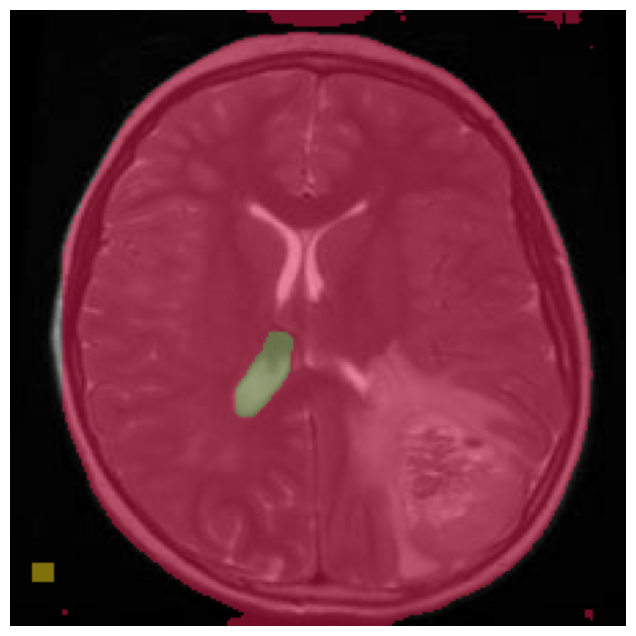

In [44]:
masks = masks.cpu().numpy().astype(bool)
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))

In [41]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.5,
    iou=0.6)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.text_prompt(text='Tumor')


image 1/1 /content/CsiLab-BrainTumor-3/train/100_jpg.rf.52a53d8063b496f45ec1439a25ca36f8.jpg: 1024x1024 3 objects, 172.1ms
Speed: 6.2ms preprocess, 172.1ms inference, 3.4ms postprocess per image at shape (1, 3, 1024, 1024)


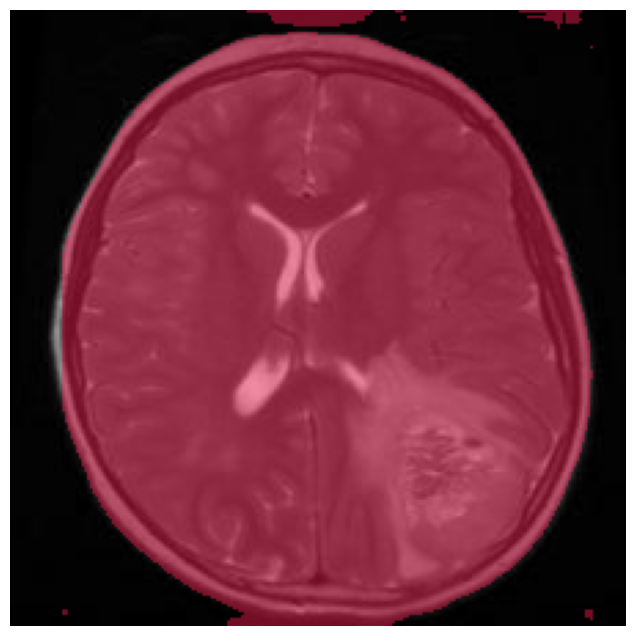

In [42]:
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))